# Sweep TMRCA


Extract TMRCA for swept individuals and for full sample. This serve as a sanity check. We expect sweep clade TMRCA to reflect the criteria by which swept windows are selected. So we want to retrieve that and we want to show that this applies to the entire extended peak region, suggesting that it can be considered one and not multiple sweeps.

In [1]:
import re, os, sys, pickle, pickle, subprocess, bisect, random
from pathlib import Path
import numpy
import pandas
import scipy

from pandas import DataFrame, Series
from sklearn.decomposition import PCA

from ete3 import Tree
from scipy.cluster.hierarchy import dendrogram, linkage

import pyfaidx

# my own libaries
from ChromosomeWindows import window
import genominterv

numpy.random.seed(7)
random.seed(7)

In [2]:
import re, os, sys, pickle, math, collections, random
from pathlib import Path
import numpy
import pandas
from pandas import DataFrame
from ete3 import Tree
from scipy.cluster.hierarchy import dendrogram, linkage
import subprocess
import bisect
import pyfaidx

Plotting setup:

In [3]:
%matplotlib inline

# Make inline plots vector graphics instead of raster graphics
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina', 'png')

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D

from mpl_toolkits.basemap import Basemap
#matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)

import mpld3

import seaborn as sns
sns.set() # sets seaborn default "prettyness:
sns.set_style("whitegrid")
sns.set_context("paper")

# lowess for plotting
from statsmodels.nonparametric.smoothers_lowess import lowess

set1 = {'red': '#e41a1c', 'blue': '#377eb8', 'green': '#4daf4a',
        'purple': '#984ea3', 'orange': '#ff7f00', 
        'yellow': '#ffff33', 'brown': '#a65628'}

Ignore deprecation warnings from mainly seaborn:

In [4]:
# silence deprecation warnings (lots from seaborn)
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=numpy.VisibleDeprecationWarning)
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

### Analysis dirs

In [5]:
root_dir = Path(os.environ['HOME'], 'simons/faststorage/people/kmt')
meta_data_dir = Path(os.environ['HOME'], 'simons/faststorage/data/metadata')
steps_dir = root_dir / 'steps'
argweaver_dir = steps_dir / 'argweaver/output'
results_dir = root_dir / 'results'
figures_dir = root_dir / 'figures'
data_dir = root_dir / 'data'
pi_dir = steps_dir / 'pi_stores'
dist_dir = steps_dir / 'dist_stores'
#pi_dir = root_dir / 'old_pi_stores'
male_x_haploid_dir = steps_dir / 'male_x_haploids'

reference_genome_file = Path('/home', 'kmt', 'simons', 
                        'faststorage', 'cteam_lite_public3', 'FullyPublic', 'Href.fa')

Import variables global to the entire analysis:

In [6]:
import analysis_globals

Local code in the scripts dir on the cluster:

In [7]:
scripts_dir = root_dir / 'scripts'
if str(scripts_dir) not in sys.path:
    sys.path.append(str(scripts_dir))

import simons_meta_data
import hg19_chrom_sizes

from toggle_code_and_errors import toggle_code_html, toggle_errors_html

## Convenience functions

In [8]:
def silent_nanmean(x):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        return numpy.nanmean(x)
    
def ident_scalar(s):
    x = s.unique()
    assert(len(x)) == 1
    return x[0]

def flatten_column_index(df):
    df.columns = ['_'.join(col).strip() for col in df.columns.values]


In [9]:
import time
class Timer:    
    def __enter__(self):
        self.start = time.clock()
        return self

    def __exit__(self, *args):
        self.end = time.clock()
        self.interval = self.end - self.start
        print("{:.0f} min {:.1f} sec".format(self.interval//60, self.interval % 60))

## Load meta data

In [10]:
# easy loading of meta data in a consistent manner across code
individuals, populations, regions = simons_meta_data.get_meta_data(meta_data_dir=meta_data_dir)

pop_categories = pandas.read_hdf(str(results_dir / 'population_categories.store'), 'sr')
region_categories = pandas.read_hdf(str(results_dir / 'region_categories.store'), 'sr')
# region_colors = dict(zip(list(region_categories), 
#                          ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', 
#                           '#ff7f00', '#ffff33', '#a65628']))

region_colors = dict(zip(list(region_categories), 
                         ['#e41a1c', '#377eb8',  '#984ea3', '#4daf4a',
                          '#ff7f00', '#ffff33', '#a65628']))

chromosome_lengths = dict((k.replace('chr', ''), v) for k, v in hg19_chrom_sizes.hg19_chrom_sizes.items())

## Load sweep data

In [11]:
non_afr_total_swept = pandas.read_hdf(results_dir / 'non_afr_total_swept.hdf')
afr_total_swept = pandas.read_hdf(results_dir / 'afr_total_swept.hdf')

In [12]:
non_afr_total_swept.head()

,index,start,end,is_non_african,nr_swept,total,pos,prop_swept
0,1,2700000,2800000,True,0.0,139,2750000.0,0.0
1,3,2800000,2900000,True,0.0,140,2850000.0,0.0
2,5,2900000,3000000,True,0.0,140,2950000.0,0.0
3,7,3000000,3100000,True,0.0,140,3050000.0,0.0
4,9,3100000,3200000,True,0.0,140,3150000.0,0.0


Make sure the index is 0, 1, 2 ...

In [13]:
non_afr_total_swept.reset_index(drop=True, inplace=True)
print(len(non_afr_total_swept))
non_afr_total_swept.tail()

1385


,index,start,end,is_non_african,nr_swept,total,pos,prop_swept
1380,2760,154100000,154200000,True,44.0,140,154150000.0,0.314286
1381,2762,154200000,154300000,True,44.0,140,154250000.0,0.314286
1382,2764,154300000,154400000,True,44.0,140,154350000.0,0.314286
1383,2766,154400000,154500000,True,40.0,140,154450000.0,0.285714
1384,2768,154800000,154900000,True,0.0,140,154850000.0,0.000000


## Compute TMRCA stats using ARGweaver

We use the 90% set for this

Load sweep regions:

In [14]:
df = pandas.read_hdf(analysis_globals.results_dir / 'extended_peak_regions_90%.hdf')
df.head()

,pos,peak_start,peak_end,peak_prop_swept,start_pos,end_pos,prop_swept,swept_indivs
0,19850000.0,19800000,19900000,0.828571,19600000,20100000,0.771429,"['B_Australian-4', 'B_Crete-2', 'B_Dai-4', 'B_..."
1,21250000.0,21200000,21300000,0.814286,21100000,21600000,0.785714,"['B_Australian-4', 'B_Crete-2', 'B_French-3', ..."
2,36300000.0,36200000,36400000,0.664286,36000000,36400000,0.635714,"['B_Crete-2', 'B_Dai-4', 'B_French-3', 'B_Han-..."
3,37500000.0,37300000,37700000,0.507143,37200000,37700000,0.500000,"['B_Crete-2', 'B_Dai-4', 'B_Han-3', 'B_Karitia..."
4,49750000.0,49500000,50000000,0.528571,49500000,50000000,0.528571,"['B_Australian-4', 'B_French-3', 'B_Papuan-15'..."


In [15]:
sweeps_for_dating = [list(x) for x in df.values]  
for i in range(len(sweeps_for_dating)):
    sweeps_for_dating[i][7] = eval(sweeps_for_dating[i][7])

In [16]:
def clade_tmrca(tree, clade_leaves, discrete_time_intervals=None):
    """
    Compute the TMRCA of a a set of leaves relative to the TMRCA 
    of all leaves. Used to compute the relative TMRCA of non-Africans.
    """
    add_node_heights(tree, discrete_time_intervals=discrete_time_intervals)
    clade_root = tree.get_common_ancestor(*clade_leaves)
    root = tree.get_tree_root()
    return clade_root.height, root.height

def add_node_heights(tree, discrete_time_intervals):
    """
    Add height of each internal node as node attribute.
    Assumes an (ultrametric) tree.
    """
    if tree.is_leaf():
        tree.height = 0
        return tree.dist, []
    else:
        child_node_heights = list()
        this_node_heights = list()
        for c in tree.children:
            this_height, child_node_hts = add_node_heights(c, discrete_time_intervals)
            this_node_heights.append(this_height)
            child_node_heights.extend(child_node_hts)

        # take care of round off errors:
        this_node_height = numpy.mean(this_node_heights)
        # and check they are no larger than 0.5
        assert max(this_node_heights) - min(this_node_heights) <= 0.5, this_node_heights

        # take care of round off errors to coalescences in same interval get same height
        if discrete_time_intervals:
            this_node_height = round_to_closest(this_node_height, discrete_time_intervals)

        tree.height = this_node_height

        parent_node_height = this_node_height + tree.dist
        return parent_node_height, [this_node_height] + child_node_heights

    
# def node_descendant_counts(tree):
#     """
#     Get number of leaves below each internal node in an 
#     ultramemtric tree from a postorder traversal. The order of 
#     nodes returned is the same as for node_heights. This 
#     traversal uses the order of children as in the t.children 
#     attribute (not the same order as t.traverse('postorder') ).
#     """
#     if tree.is_leaf():
#         return 1, []
#     else:
#         child_leaf_counts = list()
#         total_leaves = 0
#         for c in tree.children:
#             child_leaf_count, child_leaf_list = node_descendant_counts(c)
#             child_leaf_counts.extend(child_leaf_list)
#             total_leaves += child_leaf_count
#         return total_leaves, [total_leaves] + child_leaf_counts

# def node_heights(tree):
#     """
#     Get height of each internal node in an ultramemtric 
#     tree from a postorder traversal. This traversal uses
#     the order of children as in the t.children attribute 
#     (not the same order as t.traverse('postorder') ).
#     """
#     if tree.is_leaf():
#         return tree.dist, []
#     else:
#         child_node_heights = list()
#         this_node_heights = list()
#         for c in tree.children:
#             this_height, child_node_hts = node_heights(c)
#             this_node_heights.append(this_height)
#             child_node_heights.extend(child_node_hts)

#         # take care of round off errors:
#         this_node_height = numpy.mean(this_node_heights)
#         # and check they are no larger than 0.5
#         assert max(this_node_heights) - min(this_node_heights) <= 0.5, this_node_heights

#         parent_node_height = this_node_height + tree.dist
#         return parent_node_height, [this_node_height] + child_node_heights


# def tmrca_stats(tree):
#     """
#     Compute:
#     TMRCA: time to TMRCA of tree.
#     TMRCA_half: time until at a clade consist of at least 50% of sample.
#     Coal_half: time until at least half the sample is part of any subtree (have coalesced).
#                Same as TMRCA_half but not requireing that they are in a single subtree.
#     """
#     total_height, heights = node_heights(tree)
#     total_leaves, leaf_counts = node_descendant_counts(tree)
#     min_half = math.ceil(len(tree)/2)
    
#     coal_half = sorted(heights)[min_half - 2] # -2 because index 0 is the height where two has coalesced
#     tmrca = max(heights)
#     for lc, h in sorted(zip(leaf_counts, heights)):
#         if lc >= min_half:
#             tmrca_half = h
#             break
            
#     return tmrca, tmrca_half, coal_half


non_afr_leaves = list()
for indiv, d in individuals.items():
    if d['Region'] != 'Africa' and d['Genetic sex assignment'] == 'XY':
#         non_afr_leaves.append(indiv + '-A')
        non_afr_leaves.append(indiv)
        
def tree_stats(df, clade_indivs):
    
    clade_indivs = [x + '-A' for x in clade_indivs]
    stats_list = list()
    for row in df.itertuples():
        tree_start, tree_end = int(row.start), int(row.end)
        tree = Tree(row.tree)  
        stats_list.append((tree_start, tree_end, *clade_tmrca(tree, clade_indivs)))
    return DataFrame.from_records(stats_list, 
                                  columns=['tree_start', 'tree_end', 
#                                            'tmrca', 'tmrca_half', 'coal_half', 'non_afr_tmrca']
                                           'sweep_tmrca', 'tmrca']
                                 )

In [17]:
def extract_region_tmrca_stats(peak_pos, win_start, win_end, prop_swept,swept_indivs):
    tmpl = '/home/kmt/simons/faststorage/people/kmt/steps/argweaver/output/World/X-{:09d}-{:09d}.tsv.gz'
    df_list = list()
    for offset in range(0, win_end-win_start, 100000):
        file_start, file_end = win_start + offset, win_start + offset + 100000
        print('   ', file_start, file_end)
        input_table_df = pandas.read_table(tmpl.format(file_start, file_end))
        df = (input_table_df
              .groupby(['chain', 'sample'])
              .apply(tree_stats, clade_indivs=swept_indivs)
              .reset_index()
             )
        df['peak_pos'] = peak_pos
        df['prop_swept'] = prop_swept
        df['win_start'] = win_start
        df['win_end'] = win_end
        df['file_start'] = file_start
        df['file_end'] = file_end                                           
        df_list.append(df)
    return pandas.concat(df_list)

In [18]:
peak_pos_list, peak_start_list, peak_end_list, peak_prop_swept, \
        win_start_list, win_end_list, prop_swept_list, swept_indiv_lists = zip(*sweeps_for_dating)


args_iter = zip(peak_pos_list, win_start_list, win_end_list, prop_swept_list, swept_indiv_lists)

from multiprocessing import Pool, cpu_count
with Pool(int(os.environ['SLURM_CPUS_PER_TASK'])) as p:
    argweaver_sweep_tmrca = pandas.concat(p.starmap(extract_region_tmrca_stats, args_iter))

    19600000 19700000
    21100000 21200000
    37200000 37300000
    36000000 36100000
    49500000 49600000
    50800000 50900000
    54000000 54100000
    64600000 64700000
    73800000 73900000
    73000000 73100000
    73900000 74000000
    37300000 37400000
    54100000 54200000
    36100000 36200000
    73100000 73200000
    21200000 21300000
    64700000 64800000
    50900000 51000000
    49600000 49700000
    74000000 74100000
    19700000 19800000
    64800000 64900000
    54200000 54300000
    73200000 73300000
    37400000 37500000
    51000000 51100000
    21300000 21400000
    74100000 74200000
    49700000 49800000
    36200000 36300000
    73300000 73400000
    54300000 54400000
    64900000 65000000
    51100000 51200000
    19800000 19900000
    21400000 21500000
    37500000 37600000
    74200000 74300000
    73400000 73500000
    49800000 49900000
    65000000 65100000
    76700000 76800000
    51200000 51300000
    36300000 36400000
    37600000 37700000
    215000

In [19]:
argweaver_sweep_tmrca.head()

,chain,sample,level_2,tree_start,tree_end,sweep_tmrca,tmrca,peak_pos,prop_swept,win_start,win_end,file_start,file_end
0,1,0,0,19600000,19600232,8051.715865,18044.607932,19850000.0,0.771429,19600000,20100000,19600000,19700000
1,1,0,1,19600232,19600298,8051.715865,18044.603966,19850000.0,0.771429,19600000,20100000,19600000,19700000
2,1,0,2,19600298,19600799,8051.715865,18044.603966,19850000.0,0.771429,19600000,20100000,19600000,19700000
3,1,0,3,19600799,19600806,8051.715279,18044.603820,19850000.0,0.771429,19600000,20100000,19600000,19700000
4,1,0,4,19600806,19601340,8051.702779,18044.600695,19850000.0,0.771429,19600000,20100000,19600000,19700000


In [20]:
argweaver_sweep_tmrca.to_hdf(results_dir / 'argweaver_sweep_tmrca.hdf', 'df', format="table", mode='w') 

In [16]:
#argweaver_sweep_tmrca = pandas.read_hdf(results_dir / 'argweaver_sweep_tmrca.hdf') 

We dicard the first 1000 steps of the Markov chain. As shown below, the two independent runs for each window produces very similar summary statistics.

In [17]:
argweaver_tmrca_100kb = (argweaver_sweep_tmrca
      .loc[lambda df: df['sample'] > 1000]
      .groupby(['peak_pos', 'prop_swept', 'win_start', 'win_end', 'file_start', 'file_end', 'chain'])
      .apply(lambda df: DataFrame({'tmrca': [numpy.average(df.tmrca, weights=df.tree_end-df.tree_start)],
                                   'sweep_tmrca': [numpy.average(df.sweep_tmrca, weights=df.tree_end-df.tree_start)]}))      
      .reset_index(level=['peak_pos', 'prop_swept', 'win_start', 'win_end', 'file_start', 'file_end', 'chain'])
     )
argweaver_tmrca_100kb.to_hdf(results_dir / 'argweaver_tmrca_100kb.hdf', 'df', format='table', mode='w')

In [18]:
argweaver_tmrca_100kb.head()

,peak_pos,prop_swept,win_start,win_end,file_start,file_end,chain,tmrca,sweep_tmrca
0,19850000.0,0.771429,19600000,20100000,19600000,19700000,1,27276.598860,6785.540255
0,19850000.0,0.771429,19600000,20100000,19600000,19700000,2,28593.525467,4885.110458
0,19850000.0,0.771429,19600000,20100000,19700000,19800000,1,26644.517051,4307.284280
0,19850000.0,0.771429,19600000,20100000,19700000,19800000,2,26192.964988,5716.460224
0,19850000.0,0.771429,19600000,20100000,19800000,19900000,1,24634.894712,3194.584666


The ARGweaver analysis uses a per generation mutation rate of 1.8e-8, wich assuming a generation time of 29 years, corresponds to a mutation rate per year of ~6e-10.

Alternatively we could have assumed a generation time of 25 years and a mutation rate of 1.5e-8 producing the same per year mutation rate.

In [26]:
def argweaver_gen_to_years(sr):
#     return sr * 29 # argweaver uses a per generation mutation rate of 1.8e-8
#    return sr * 25 * 1.8e-8/1.5e-8
    return sr * 29 * (analysis_globals.mut_per_year * analysis_globals.gen_time) / 1.8e-8 

In [27]:
argweaver_tmrca_100kb[['sweep_tmrca', 'tmrca']].median().transform(argweaver_gen_to_years)

sweep_tmrca     52633.976789
tmrca          542702.915269
dtype: float64

In [28]:
plot_df = (pandas
           .melt(argweaver_tmrca_100kb, id_vars=['peak_pos', 'prop_swept', 'win_start', 'win_end', 
                                                 'file_start', 'file_end', 'chain'], 
                 value_vars=['sweep_tmrca', 'tmrca'])
           .assign(years = lambda df: argweaver_gen_to_years(df.value))
          )

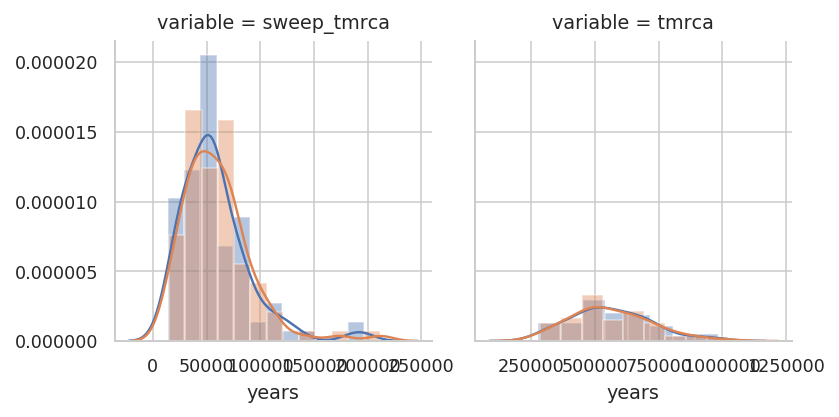

In [29]:
g = sns.FacetGrid(data=plot_df, col='variable', hue='chain', sharex=False)
g.map(sns.distplot, 'years').set_axis_labels("years", "") ;

Shows good correspondence between results from the two independends runs for each window.

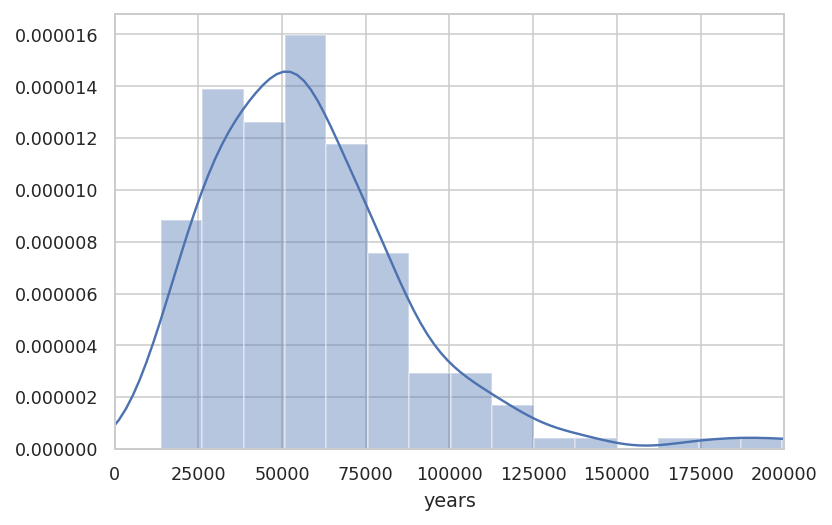

In [30]:
g = sns.distplot(plot_df.loc[lambda df: df.variable == 'sweep_tmrca'].years)
g.set_xlim(0, 200000) ; 

It seems that the TMRCA of most 100kb windows in extended peaks are lower than our cutoff. That is expected and is probably mostly a direct result of how the windows are selected. You can compare to the distribution of pwdist of swept regions and see that they look quite similar.

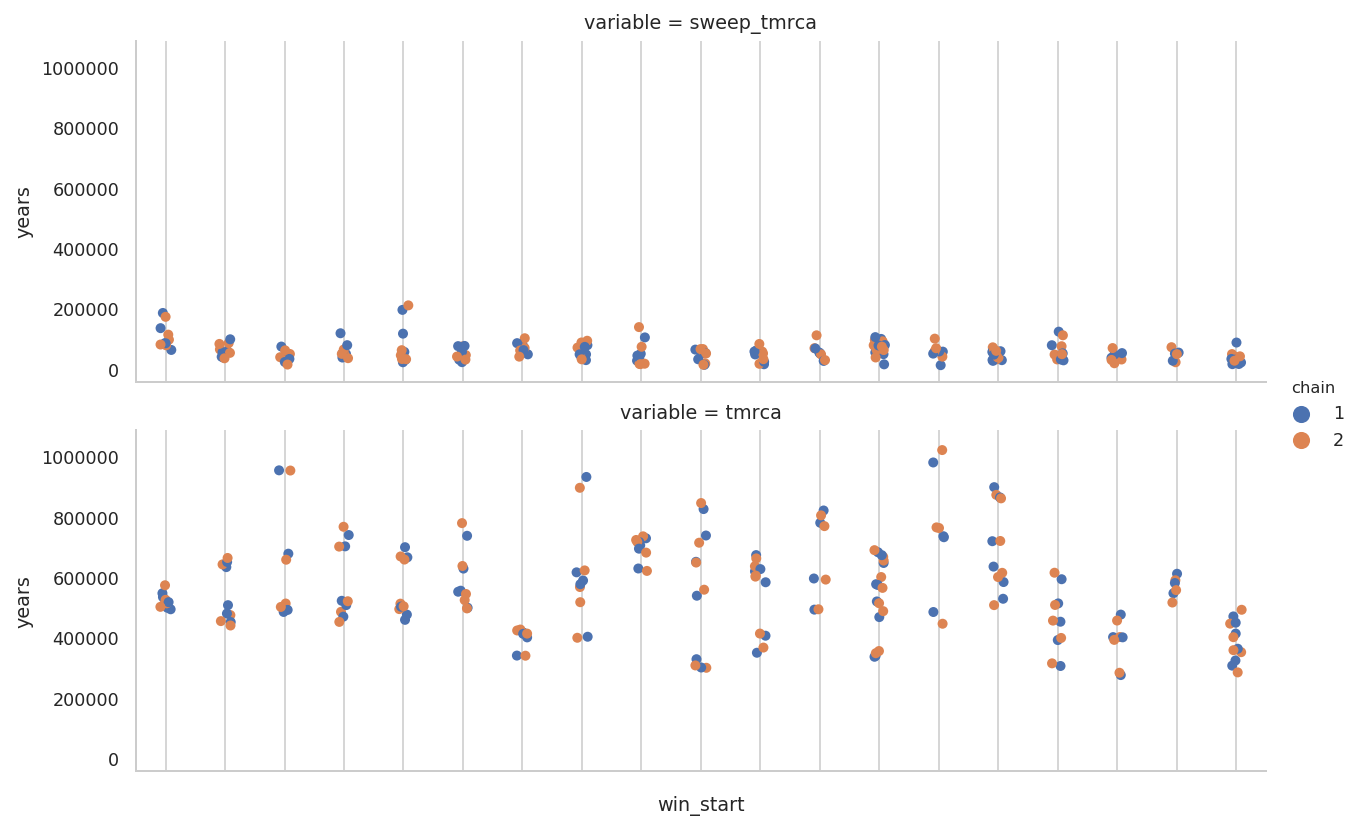

In [31]:
with sns.axes_style('whitegrid'):
    g = sns.catplot(data=plot_df, x="win_start", y="years", 
                       row="variable", hue='chain', kind='strip', height=3, aspect=3)
    g.set_xticklabels(rotation=90)
for ax in g.axes.flatten():
    ax.grid()    
#    ax.set_ylim(0, 120000)

Looking at TMRCA for the individual 100kb windows there seem to be a good consistency across the swept regions. It also shows that some regions have windows with more than one sweep. For some regions this applies to the entire region.

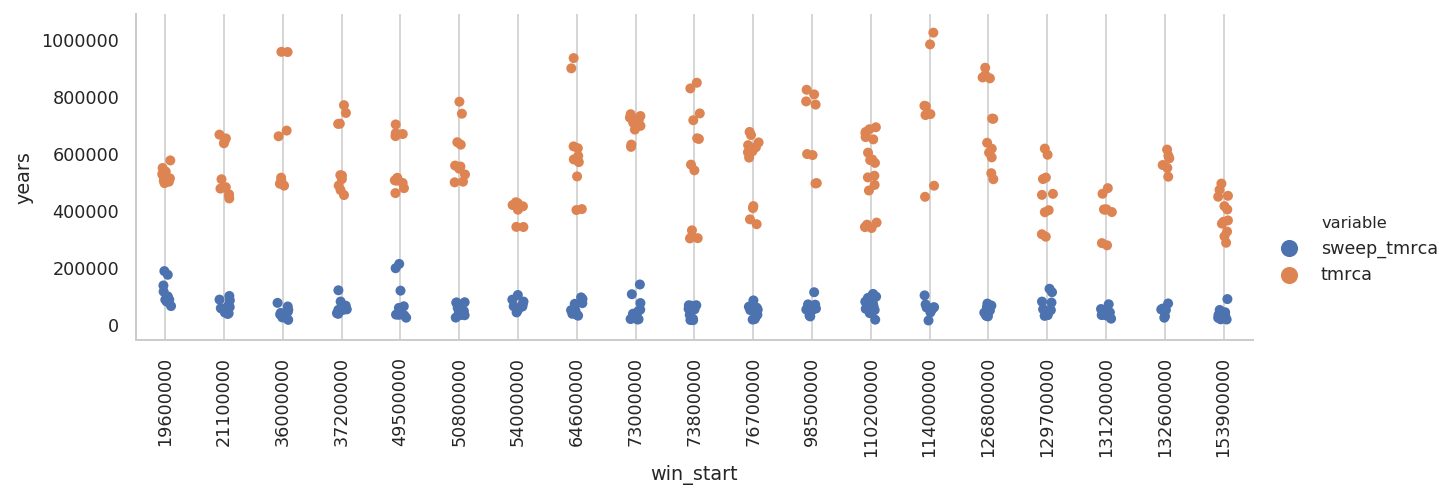

In [32]:
with sns.axes_style('whitegrid'):
    g = sns.catplot(data=plot_df, x="win_start", y="years", 
                       hue="variable", kind='strip', height=3, aspect=3)
    g.set_xticklabels(rotation=90)
for ax in g.axes.flatten():
    ax.grid()    
#    ax.set_ylim(0, 120000)

If we assume that each region is one haplotype (except for the outliers), the TMRCA for the extended peak regions are distributed like this:

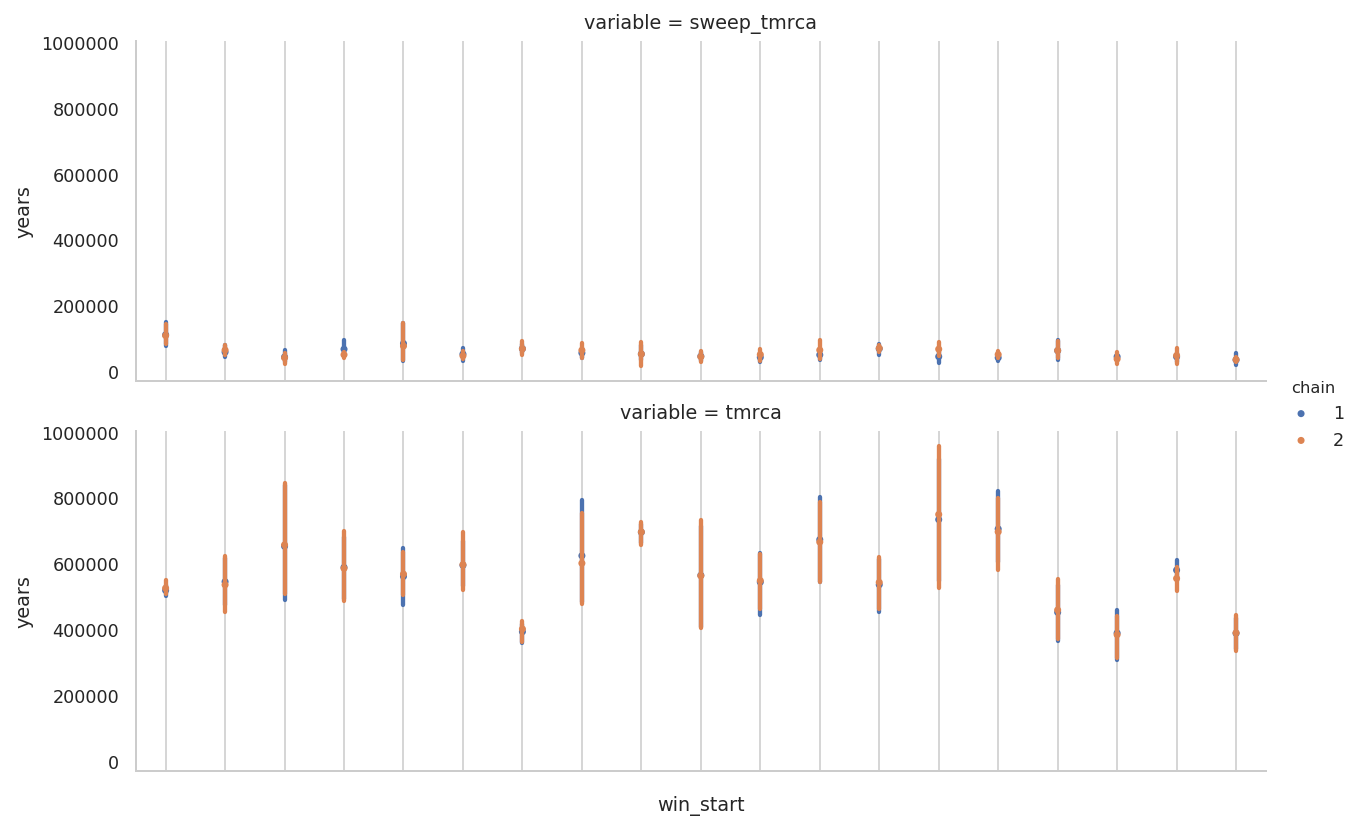

In [33]:
with sns.axes_style('whitegrid'):
    g = sns.catplot(data=plot_df, x="win_start", y="years", 
                       row="variable", hue='chain', kind='point', join=False, height=3, aspect=3, scale = 0.5)
    g.set_xticklabels(rotation=90)
for ax in g.axes.flatten():
    ax.grid()    
#    ax.set_ylim(0, 120000)

Mean TMRCA for windows in each region:

Grouping chains too:

134325.58139534883


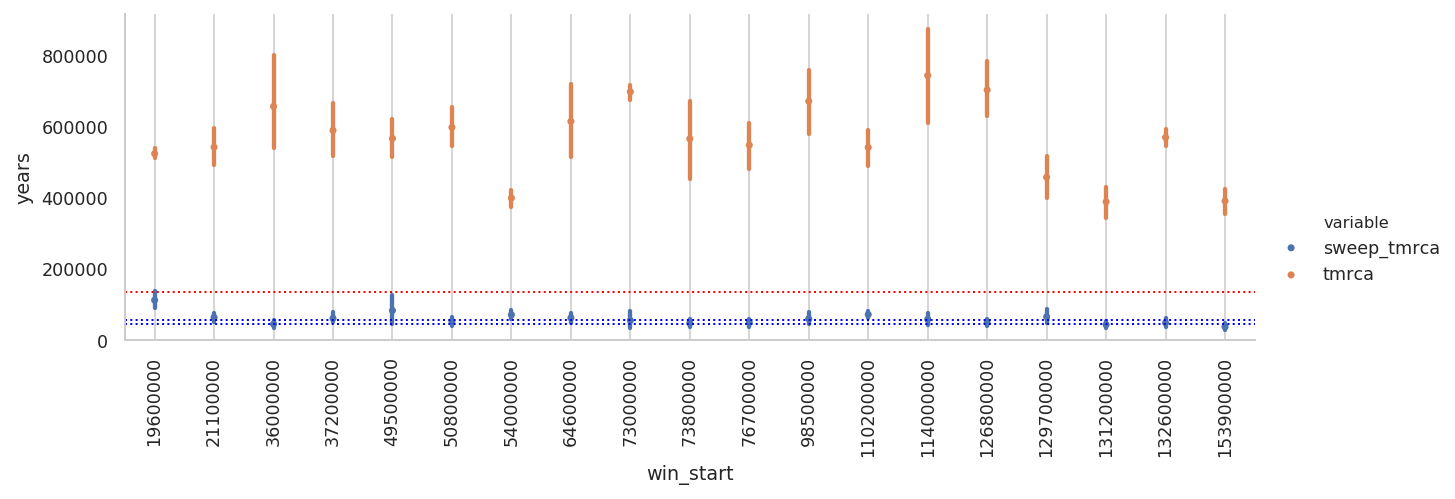

In [43]:
with sns.axes_style('whitegrid'):
    g = sns.catplot(data=plot_df, x="win_start", y="years", 
                        hue="variable", kind='point', join=False, height=3, aspect=3, scale = 0.5)
    g.set_xticklabels(rotation=90)
    plt.ylim(0,)
for ax in g.axes.flatten():
    ax.grid()

    # Punctuated bursts in human male demography inferred from 1,244 worldwide Y-chromosome sequences:
    OoA = (76000 * 0.76e-9) / analysis_globals.mut_per_year # 76000 years assuming 0.76e-9 mut rate
    print(OoA)    
    ax.axhline(OoA, color='red', linestyle='dotted', linewidth=1, zorder=1)

    ax.axhline(45000, color='blue', linestyle='dotted', linewidth=1, zorder=1)
    ax.axhline(55000, color='blue', linestyle='dotted', linewidth=1, zorder=1)

    
#    ax.set_ylim(0, 120000)

plt.savefig(str(figures_dir / 'sweep_tmrca.pdf'))

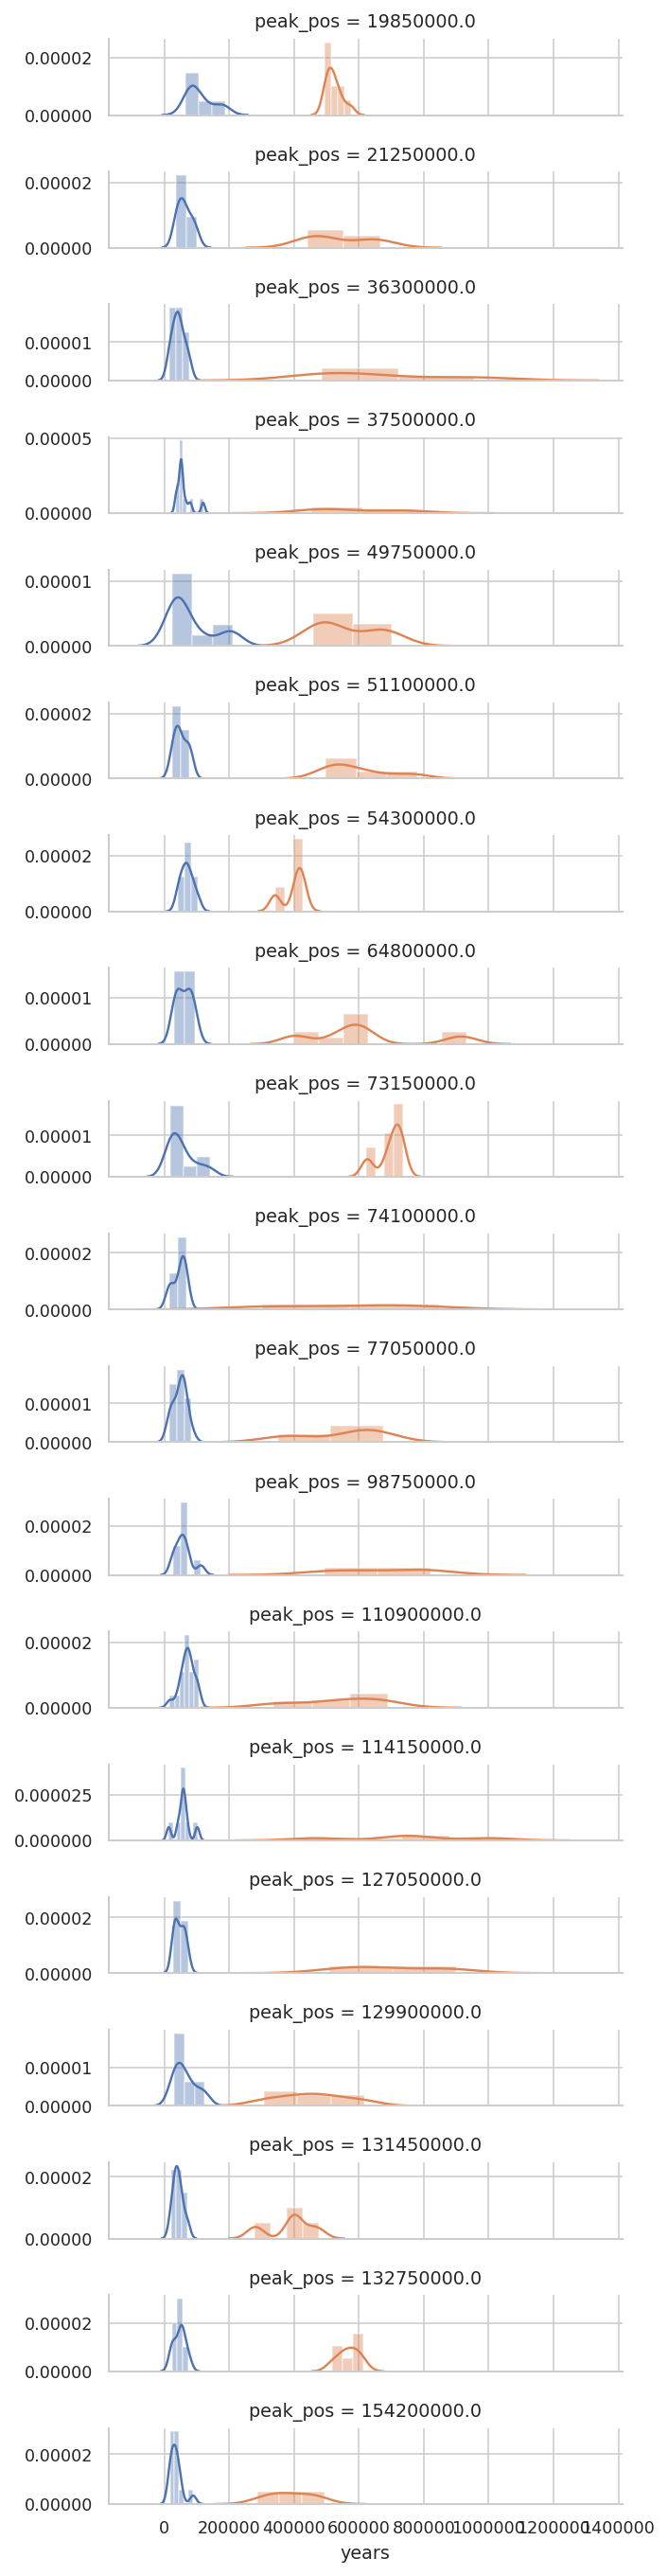

In [56]:
g = sns.FacetGrid(plot_df, row="peak_pos", hue='variable', sharey=False, height=1, aspect=5)
g = g.map(sns.distplot, "years")

This tells us that for most sweeps the swept individuals in the extended peak regions do correspond to one clade with a TMRCA capped by the way we call sweeps. Some sweeps are higher, showing that these are either more than one sweep or that the `swept_indivs` include individuals that are not swept.

This does not tells us anything useful about the dates other than they are as expected from the way we call sweeps.

It *does* tell us that some very wide regions have an early TMRCA. It does *not* tell us that this can not be a the outcome of selecting low dist regions from a neutral system.

In [35]:
plot_df2 = (plot_df[['win_start', 'win_end', 'variable', 'peak_pos', 'prop_swept', 'years']]
            .groupby(['win_start', 'win_end', 'variable'])
            .mean().reset_index()
            
           )
plot_df2.head()

,win_start,win_end,variable,peak_pos,prop_swept,years
0,19600000,20100000,sweep_tmrca,19850000.0,0.771429,110869.280532
1,19600000,20100000,tmrca,19850000.0,0.771429,522658.171722
2,21100000,21600000,sweep_tmrca,21250000.0,0.785714,62508.046951
3,21100000,21600000,tmrca,21250000.0,0.785714,540937.924011
4,36000000,36400000,sweep_tmrca,36300000.0,0.635714,43498.490958


In [36]:
plot_df.head()

,peak_pos,prop_swept,win_start,win_end,file_start,file_end,chain,variable,value,years
0,19850000.0,0.771429,19600000,20100000,19600000,19700000,1,sweep_tmrca,6785.540255,136325.273471
1,19850000.0,0.771429,19600000,20100000,19600000,19700000,2,sweep_tmrca,4885.110458,98144.583043
2,19850000.0,0.771429,19600000,20100000,19700000,19800000,1,sweep_tmrca,4307.284280,86535.734113
3,19850000.0,0.771429,19600000,20100000,19700000,19800000,2,sweep_tmrca,5716.460224,114846.861717
4,19850000.0,0.771429,19600000,20100000,19800000,19900000,1,sweep_tmrca,3194.584666,64180.980718


## Table for SOM with mean TMRCA stats for each sweep

In [58]:
mean_sweep_tmrca_stats = (plot_df2
 .set_index(['win_start', 'win_end', 'peak_pos', 'prop_swept', 'variable', ])
 .unstack()
 .reset_index(col_level=1)
 .reset_index(drop=True)
)
mean_sweep_tmrca_stats.columns = sweep_tmrca_stats.columns.get_level_values(1)

mean_sweep_tmrca_stats.to_csv(results_dir / 'mean_sweep_tmrca_stats.csv', index=False)


In [59]:
mean_sweep_tmrca_stats

variable,win_start,win_end,peak_pos,prop_swept,sweep_tmrca,tmrca
0,19600000,20100000,19850000.0,0.771429,110869.280532,522658.171722
1,21100000,21600000,21250000.0,0.785714,62508.046951,540937.924011
2,36000000,36400000,36300000.0,0.635714,43498.490958,655377.387459
3,37200000,37700000,37500000.0,0.500000,60003.585536,587797.077317
4,49500000,50000000,49750000.0,0.528571,81727.011727,565174.785827
5,50800000,51300000,51100000.0,0.407143,50908.822919,596467.520572
6,54000000,54400000,54300000.0,0.735714,69744.554147,397934.172497
7,64600000,65100000,64800000.0,0.714286,60987.262135,613095.188369
8,73000000,73500000,73150000.0,0.385714,53689.248065,696302.828136
9,73800000,74400000,74100000.0,0.314286,46191.290160,564275.246409


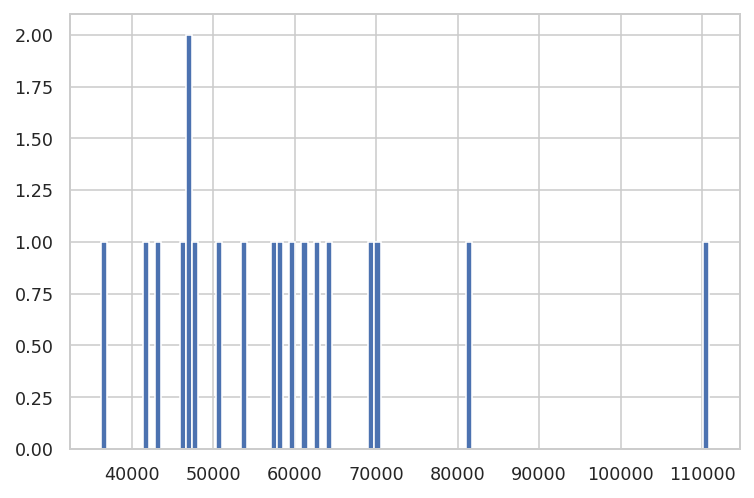

In [60]:
plt.hist(mean_sweep_tmrca_stats.sweep_tmrca, bins=100) ;